In [1]:
%load_ext autoreload
%autoreload 2

import traceback
from enum import Enum
from typing import Optional

import pandas as pd
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

from pyquant.common import *
from pyquant.vol_surface import VolSurfaceChainSpace
from pyquant.heston import *

plt.style.use("dark_background")

In [2]:
class InstrumentId(Enum):
    BTC = 0
    ETH = 1

class InstrumentType(Enum):
    FUTURE = 1
    OPTION = 2
    FUTURE_COMBO = 3
    OPTION_COMBO = 4
    CALL_OPTION = 5
    PUT_OPTION = 6
    ASSET = 7

In [3]:
INSTRUMENT = InstrumentId.ETH
MD_PATH = 'market_data/books_resampled_15min.hdf'
CALIBR_DATA_DIR = 'calibration_data'

# Load and preprocess market data

In [4]:
def preprocess_data(data: pd.DataFrame, instr_id: InstrumentId):
    YEAR_IN_MS = 365 * 24 * 3600 * 1000
    data = data.rename(columns={'maturity': 'expiry_ts'})
    data['expiry_ts'] *= 1000  # convert seconds to ms
    data['time_to_maturity'] = (data['expiry_ts'] - data['timestamp']) / YEAR_IN_MS
    data['price'] = -1.0

    # Where both best bid and ask are present, use midprice as a price
    data.loc[(data['best_bid_price'] > 0) & (data['best_ask_price'] > 0), "price"] = \
        (data['best_bid_price'] + data['best_ask_price']) / 2

    # At least one of best bid and best ask are present in data,
    # this was ensured at the data processing step.

    # Where best bid is not present, use best ask as a price
    data.loc[data['best_bid_price'] < 0, "price"] = data['best_ask_price']
    # Where best ask is not present, use best bid as a price
    data.loc[data['best_ask_price'] < 0, "price"] = data['best_bid_price']

    # Select coin
    data.query(f'instrument_id == {instr_id.value}', inplace=True)
    data.drop(columns='instrument_id', inplace=True)

    columns = ['sample_idx', 'timestamp', 'instrument_type', 'strike', 'expiry_ts',
               'time_to_maturity', 'price', 'best_bid_price', 'best_ask_price',
               'bid_amount_total', 'ask_amount_total', 'bid_vwap', 'ask_vwap']
    return data[columns].reset_index(drop=True)

In [5]:
market_data = preprocess_data(pd.read_hdf(MD_PATH), INSTRUMENT)

In [6]:
market_data

,sample_idx,timestamp,instrument_type,strike,expiry_ts,time_to_maturity,price,best_bid_price,best_ask_price,bid_amount_total,ask_amount_total,bid_vwap,ask_vwap
0,1,1701377983884,5,1850.0,1701464400000,0.002740,0.11250,-1.0000,0.1125,0.0,7.0,-1.000000,0.112500
1,1,1701377983884,6,1750.0,1701464400000,0.002740,0.00020,-1.0000,0.0002,0.0,670.0,-1.000000,0.000362
2,1,1701377983884,6,1800.0,1701464400000,0.002740,0.00010,-1.0000,0.0001,0.0,731.0,-1.000000,0.002613
3,1,1701377983884,5,1750.0,1701464400000,0.002740,0.16600,-1.0000,0.1660,0.0,7.0,-1.000000,0.166000
4,1,1701377983885,5,1800.0,1701464400000,0.002740,0.13950,-1.0000,0.1395,0.0,7.0,-1.000000,0.139500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5215660,12792,1714011211821,1,-1.0,1743109200000,0.922691,3430.50000,3429.0000,3432.0000,238655.0,230146.0,3363.172695,3468.250756
5215661,12792,1714011211876,6,2400.0,1719522000000,0.174746,0.02750,0.0270,0.0280,2328.0,2236.0,0.025560,0.029218
5215662,12792,1714011211882,6,2000.0,1727384400000,0.424061,0.03375,0.0330,0.0345,267.0,284.0,0.027637,0.035972
5215663,12792,1714011211883,6,1800.0,1727384400000,0.424061,0.02325,0.0225,0.0240,260.0,353.0,0.020802,0.024891


# Calibrate Heston model

## NumPy version

In [6]:
@nb.njit()
def calibrate_heston_sample(
    heston_calc: HestonCalc,
    instr_type: np.ndarray,
    strike: np.ndarray,
    time_to_maturity: np.ndarray,
    min_option_time_to_maturity: float,
    price: np.ndarray,
    use_cached_params: bool,
    compute_iv: bool
):
    calls_mask = ((instr_type == InstrumentType.CALL_OPTION.value) &
                  (time_to_maturity > min_option_time_to_maturity))
    puts_mask =  ((instr_type == InstrumentType.PUT_OPTION.value) &
                  (time_to_maturity > min_option_time_to_maturity))
    spot_mask = (instr_type == InstrumentType.ASSET.value)
    futures_mask = (instr_type == InstrumentType.FUTURE.value)
    futures_sorted_idxs = np.argsort(time_to_maturity[futures_mask])

    spot_price = price[spot_mask].item()

    fwd_curve = forward_curve_from_forward_rates(
        Spot(spot_price),
        ForwardRates(price[futures_mask][futures_sorted_idxs]),
        TimesToMaturity(time_to_maturity[futures_mask][futures_sorted_idxs])
    )

    buf_T = np.concatenate((time_to_maturity[calls_mask], time_to_maturity[puts_mask]))
    buf_K = np.concatenate((strike[calls_mask], strike[puts_mask]))
    buf_types = np.concatenate( (np.full(sum(calls_mask), True), np.full(sum(puts_mask), False)) )
    buf_pv = np.concatenate((price[calls_mask], price[puts_mask])) * spot_price
    sort_idxs = np.argsort(buf_T)

    volsurface_chain = VolSurfaceChainSpace(
        fwd_curve, 
        TimesToMaturity(buf_T[sort_idxs]),
        Strikes(buf_K[sort_idxs]),
        OptionTypes(buf_types[sort_idxs]),
        Premiums(buf_pv[sort_idxs]),
        compute_iv
    )

    flat_yield = FlatForwardYield(
        volsurface_chain.forward_curve().forward_yields(TimesToMaturity(np.unique(volsurface_chain.Ts))).data.mean())
    calibration_weights = CalibrationWeights(np.ones_like(volsurface_chain.Ks))

    if not use_cached_params:
        start_params = HestonParams(
            Variance(0.65),
            VarReversion(1.),
            AverageVar(1.3),
            VolOfVar(1.0),
            Correlation(-0.4),
            flat_yield
        )
        heston_calc.update_cached_params(start_params)

    heston_params, error = heston_calc.calibrate(volsurface_chain, flat_yield, calibration_weights)
    return heston_params, error, flat_yield

In [ ]:
MIN_OPTION_MATURITY = '60 days'
MIN_OPTION_MATURITY = pd.to_timedelta(MIN_OPTION_MATURITY).value / YEAR_NANOS

heston_calc = HestonCalc()
params_list = []
errors = []
flat_yields = []
exceptions = {}

sample_idx = market_data['sample_idx'].to_numpy()
instr_type = market_data['instrument_type'].to_numpy()
strike = market_data['strike'].to_numpy()
time_to_maturity = market_data['time_to_maturity'].to_numpy()
price = market_data['price'].to_numpy()

unique_sample_idxs = np.unique(sample_idx)
for i in tqdm(range(len(unique_sample_idxs))):
    curr_sample_idx = unique_sample_idxs[i]
    sample_mask = (sample_idx == curr_sample_idx)

    try:
        heston_params, error, flat_yield = calibrate_heston_sample(
            heston_calc,
            instr_type[sample_mask],
            strike[sample_mask],
            time_to_maturity[sample_mask],
            MIN_OPTION_MATURITY,
            price[sample_mask],
            use_cached_params=False,
            compute_iv=False
        )
        params_list.append(heston_params.array())
        errors.append(error.v)
        flat_yields.append(flat_yield.r)

    except Exception as e:
        params_list.append(np.full(5, np.nan))
        errors.append(np.nan)
        flat_yields.append(np.nan)

        err_count = sum(np.isnan(errors))
        err_percent = err_count / len(errors) * 100
        print(f'Error at sample #{curr_sample_idx} ({err_count}/{len(errors)}, {err_percent:.1f}%)', e)
        exceptions[curr_sample_idx] = traceback.format_exc()

In [8]:
params_history = np.stack(params_list)

In [9]:
print('Number of samples:', len(errors))
print('% of samples with failed calibration:', f'{(sum(np.isnan(errors)) / len(errors)) * 100:.1f}')

Number of samples: 269
% of samples with failed calibration: 10.0


In [10]:
with open(f'{CALIBR_DATA_DIR}/exceptions.txt', 'w') as f:
    for key, value in exceptions.items():
        print(f'Error at sample #{key}', file=f)
        print('---------------------------', file=f)
        print(value, file=f)

        # s = value.split('\n')[-2]
        # print(f'{key}: {s}', file=f)
        # if s != 'ValueError: No solution within implied vol interval':
        #     print(f'Error at sample #{key}', file=f)
        #     print('---------------------------', file=f)
        #     print(value, file=f)

In [11]:
np.save(f'{CALIBR_DATA_DIR}/params_history', params_history)
np.save(f'{CALIBR_DATA_DIR}/flat_yields', np.array(flat_yields))
np.save(f'{CALIBR_DATA_DIR}/errors', np.array(errors))

## Pandas version

In [ ]:
heston_calc = HestonCalc()
params_list = []
errors = []
flat_yields = []
exceptions = {}

for sample_idx in tqdm(market_data['sample_idx'].unique()):
    sample = market_data[market_data['sample_idx'] == sample_idx]

    calls = sample[sample['instrument_type'] == InstrumentType.CALL_OPTION.value]
    puts = sample[sample['instrument_type'] == InstrumentType.PUT_OPTION.value]
    spot = sample[sample['instrument_type'] == InstrumentType.ASSET.value]['price'].item()
    futures = sample[sample['instrument_type'] == InstrumentType.FUTURE.value] \
            .sort_values(by='time_to_maturity')

    calls.loc[:, 'price'] = calls['price'] * spot
    puts.loc[:, 'price'] = puts['price'] * spot

    try:
        fwd_curve = forward_curve_from_forward_rates(
            Spot(spot),
            ForwardRates(futures['price'].to_numpy()),
            TimesToMaturity(futures['time_to_maturity'].to_numpy())
        )

        buf_T = np.concatenate((calls['time_to_maturity'].to_numpy(), puts['time_to_maturity'].to_numpy()))
        buf_K = np.concatenate((calls['strike'].to_numpy(), puts['strike'].to_numpy()))
        buf_types = np.concatenate( (np.full(len(calls), True), np.full(len(puts), False)) )
        buf_pv = np.concatenate((calls['price'].to_numpy(), puts['price'].to_numpy()))
        sort_idxs = np.argsort(buf_T)

        volsurface_chain = VolSurfaceChainSpace(
            fwd_curve, 
            TimesToMaturity(buf_T[sort_idxs]),
            Strikes(buf_K[sort_idxs]),
            OptionTypes(buf_types[sort_idxs]),
            Premiums(buf_pv[sort_idxs]),
            compute_implied_vol=False
        )

        flat_yield = FlatForwardYield(
            volsurface_chain.forward_curve().forward_yields(TimesToMaturity(np.unique(volsurface_chain.Ts))).data.mean())
        calibration_weights = CalibrationWeights(np.ones_like(volsurface_chain.Ks))

        start_params = HestonParams(
            Variance(0.65),
            VarReversion(1.),
            AverageVar(1.3),
            VolOfVar(1.0),
            Correlation(-0.4),
            flat_yield
        )
        heston_calc.update_cached_params(start_params)
        heston_params, error = heston_calc.calibrate(volsurface_chain, flat_yield, calibration_weights)

        params_list.append(heston_params.array())
        errors.append(error.v)
        flat_yields.append(flat_yield.r)

    except Exception as e:
        params_list.append(np.full(5, np.nan))
        errors.append(np.nan)
        flat_yields.append(np.nan)

        err_count = sum(np.isnan(errors))
        err_percent = err_count / len(errors) * 100
        print(f'Error at sample #{curr_sample_idx} ({err_count}/{len(errors)}, {err_percent:.1f}%)', e)
        exceptions[curr_sample_idx] = traceback.format_exc()

In [21]:
params_history = np.stack(params_list)

In [22]:
print('Number of samples:', len(errors))
print('% of samples with failed calibration:', f'{(sum(np.isnan(errors)) / len(errors)) * 100:.1f}')

Number of samples: 142
% of samples with failed calibration: 0.7


In [ ]:
with open('exceptions.txt', 'w') as f:
    for key, value in exceptions.items():
        print(f'Error at sample #{key}', file=f)
        print('---------------------------', file=f)
        print(value, file=f)

        # s = value.split('\n')[-2]
        # print(f'{key}: {s}', file=f)
        # if s != 'ValueError: No solution within implied vol interval':
        #     print(f'Error at sample #{key}', file=f)
        #     print('---------------------------', file=f)
        #     print(value, file=f)

# Postprocess calibration results and merge with market data

In [7]:
def filter_calibr_results(params_history, flat_yields, errors, max_error):
    # v₀ (Variance), κ (VarReversion), θ (AverageVar), ε (VolOfVar), ρ (Correlation)
    small = 1e-3
    min_values = np.array([small, small, small, small, -1.0 + small])
    max_values = np.array([10.0,  500.0, 500.0, 150.0,  1.0 - small])
    mask1 = np.all(params_history > min_values, axis=1)
    mask2 = np.all(params_history < max_values, axis=1)
    mask3 = errors < max_error
    mask = mask1 & mask2 & mask3

    params_history = np.where(
        np.swapaxes(np.tile(~mask, (5, 1)), 0, 1),
        np.full((len(params_history), 5), np.nan),
        params_history
    )
    flat_yields = np.where(~mask, np.nan, flat_yields)
    errors = np.where(~mask, np.nan, errors)
    return params_history, flat_yields, errors


def make_calibration_data(market_data, params_history, flat_yields, errors, fillna=True) -> pd.DataFrame:
    calibr_data = market_data.groupby('sample_idx', as_index=False)['timestamp'].max()
    calibr_data['timestamp'] = pd.to_datetime(calibr_data['timestamp'], unit='ms')
    calibr_data[['v0', 'kappa', 'theta', 'eps', 'rho']] = params_history
    calibr_data['flat_yield'] = flat_yields
    calibr_data['error'] = errors
    if fillna:
        calibr_data.ffill(inplace=True)
    return calibr_data


def filter_isin(df1, df2, col):
    return df1[df1[col].isin(df2[col])]


# TODO: do this before calibration
def filter_no_spot(market_data, calibr_data):
    "Removes samples which don't have spot data."
    spot_mask = market_data['instrument_type'] == InstrumentType.ASSET.value
    spot_df = market_data[spot_mask].groupby('sample_idx', as_index=False).first()
    market_data = filter_isin(market_data, spot_df, 'sample_idx')
    calibr_data = filter_isin(calibr_data, spot_df, 'sample_idx')
    return market_data.reset_index(drop=True), calibr_data.reset_index(drop=True)


@nb.njit()
def _get_resampled_idxs(ts, freq) -> np.array:
    resampled_idxs = [0]
    i = 1
    while i < len(ts):
        j = resampled_idxs[-1]
        if ts[i] - ts[j] >= freq:
            resampled_idxs.append(i)
        i += 1
    return np.array(resampled_idxs)


def resample_data(market_data, calibr_data, freq):
    ts_ns = calibr_data['timestamp'].astype(int).values
    freq_ns = pd.to_timedelta(freq).value
    resampled_idxs = _get_resampled_idxs(ts_ns, freq_ns)

    calibr_data_resampled = calibr_data.iloc[resampled_idxs]
    market_data_resampled = filter_isin(market_data, calibr_data_resampled, 'sample_idx')

    return market_data_resampled.reset_index(drop=True), \
           calibr_data_resampled.reset_index(drop=True)

In [ ]:
market_data = preprocess_data(pd.read_hdf(MD_PATH), INSTRUMENT)

In [ ]:
MIN_TTM = '60days'
RESAMPLE_FREQ = '3 hours'

params_history = np.load(f'{CALIBR_DATA_DIR}/params (freq=15min, min_ttm={MIN_TTM}, no_iv)/params_history.npy')
flat_yields =    np.load(f'{CALIBR_DATA_DIR}/params (freq=15min, min_ttm={MIN_TTM}, no_iv)/flat_yields.npy')
errors =         np.load(f'{CALIBR_DATA_DIR}/params (freq=15min, min_ttm={MIN_TTM}, no_iv)/errors.npy')

params_history, flat_yields, errors = \
    filter_calibr_results(params_history, flat_yields, errors, max_error=0.01)

calibr_data = make_calibration_data(market_data, params_history, flat_yields, errors)

_market_data, _calibr_data = filter_no_spot(market_data, calibr_data)

market_data_resampled, calibr_data_resampled = \
    resample_data(_market_data, _calibr_data, RESAMPLE_FREQ)

market_data_resampled.loc[:, 'timestamp'] = \
    pd.to_datetime(market_data_resampled.loc[:, 'timestamp'], unit='ms')

market_data_resampled.loc[:, 'expiry_ts'] = \
    pd.to_datetime(market_data_resampled.loc[:, 'expiry_ts'], unit='ms')

market_data_resampled.to_parquet(f'{CALIBR_DATA_DIR}/market_data.parquet')
calibr_data_resampled.to_parquet(f'{CALIBR_DATA_DIR}/calibr_data.parquet')

## Analyze missing calibration data

In [9]:
def find_nan_intervals(arr):
    df_dict = {
        'start_idxs': [],
        'end_idxs': [],
        'length': []
    }

    i = 0
    while i < len(arr):
        if np.isnan(arr[i]):
            df_dict['start_idxs'].append(i)
            length = 1
            while i + length < len(arr) and np.isnan(arr[i + length]):
                length += 1
            df_dict['length'].append(length)
            df_dict['end_idxs'].append(i + length)
            i = i + length
        else:
            i += 1

    return pd.DataFrame(df_dict)

NaNs: 574
Unique lenghts: [ 1  2  3  4  5  6  7  8 10 24]


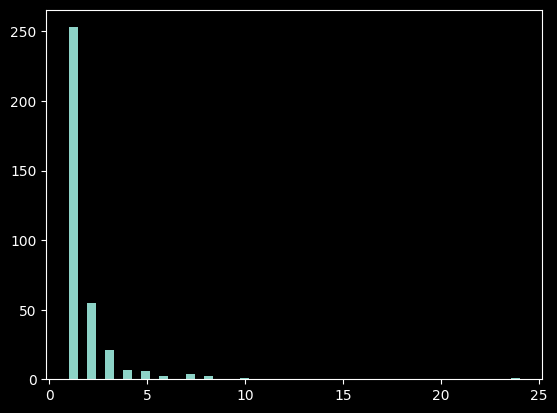

In [10]:
MIN_TTM = '60days'

params_history = np.load(f'{CALIBR_DATA_DIR}/params (freq=15min, min_ttm={MIN_TTM}, no_iv)/params_history.npy')
flat_yields =    np.load(f'{CALIBR_DATA_DIR}/params (freq=15min, min_ttm={MIN_TTM}, no_iv)/flat_yields.npy')
errors =         np.load(f'{CALIBR_DATA_DIR}/params (freq=15min, min_ttm={MIN_TTM}, no_iv)/errors.npy')

print('NaNs:', sum(np.isnan(errors)))

nan_lengths = find_nan_intervals(errors)['length']
print('Unique lenghts:', np.unique(nan_lengths))
plt.hist(nan_lengths, bins=50);

NaNs after filtering: 3244
Unique lenghts: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25
 26 27 28 30 31 32 33 34 36 37 39 41 42 44 45 48 49 52 59 61 65 76]


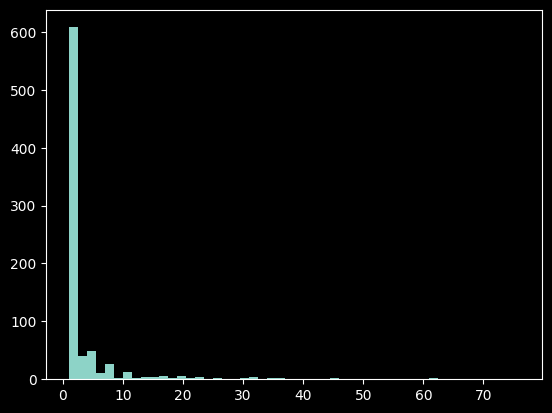

In [11]:
params_history, flat_yields, errors = \
    filter_calibr_results(params_history, flat_yields, errors, max_error=0.01)

print('NaNs after filtering:', sum(np.isnan(errors)))

nan_lengths = find_nan_intervals(errors)['length']
print('Unique lenghts:', np.unique(nan_lengths))
plt.hist(nan_lengths, bins=50);

# Plot parameters dynamics

In [12]:
def plot_dynamics(market_data, calibr_data):
    fig = make_subplots(rows=8, cols=1, shared_xaxes=True)

    spot_mask = market_data['instrument_type'] == InstrumentType.ASSET.value
    spot_df = market_data[spot_mask].groupby('sample_idx', as_index=False).first()
    assert np.all(spot_df['sample_idx'].values == calibr_data['sample_idx'].values)

    fig.add_trace(
        go.Scatter(x=calibr_data['timestamp'], y=spot_df['price'], name='Spot'),
        row=1, col=1
    )

    param_names = ['v₀ (Variance) ', 'κ (VarReversion)', 'θ (AverageVar) ', 'ε (VolOfVar)', 'ρ (Correlation)']
    for i, col in enumerate(['v0', 'kappa', 'theta', 'eps', 'rho']):
        fig.add_trace(
            go.Scatter(x=calibr_data['timestamp'], y=calibr_data[col], name=param_names[i]),
            row=2+i, col=1
        )

    fig.add_trace(
        go.Scatter(x=calibr_data['timestamp'], y=calibr_data['flat_yield'], name='Flat yield'),
        row=7, col=1
    )
    fig.add_trace(
        go.Scatter(x=calibr_data['timestamp'], y=calibr_data['error'], name='Calibr. error'),
        row=8, col=1
    )

    subplot_titles = ['Spot'] + param_names + ['Flat yield', 'Calibr. error']
    for i in range(8):
        if i == 0:
            fig['layout'][f'yaxis']['title'] = subplot_titles[i]
        else:
            fig['layout'][f'yaxis{i + 1}']['title'] = subplot_titles[i]

    fig.update_layout(xaxis_showticklabels=True, xaxis2_showticklabels=True, xaxis3_showticklabels=True,
                      xaxis4_showticklabels=True, xaxis5_showticklabels=True, xaxis6_showticklabels=True,
                      xaxis7_showticklabels=True, xaxis8_showticklabels=True)
    fig.update_traces(connectgaps=True)
    return fig

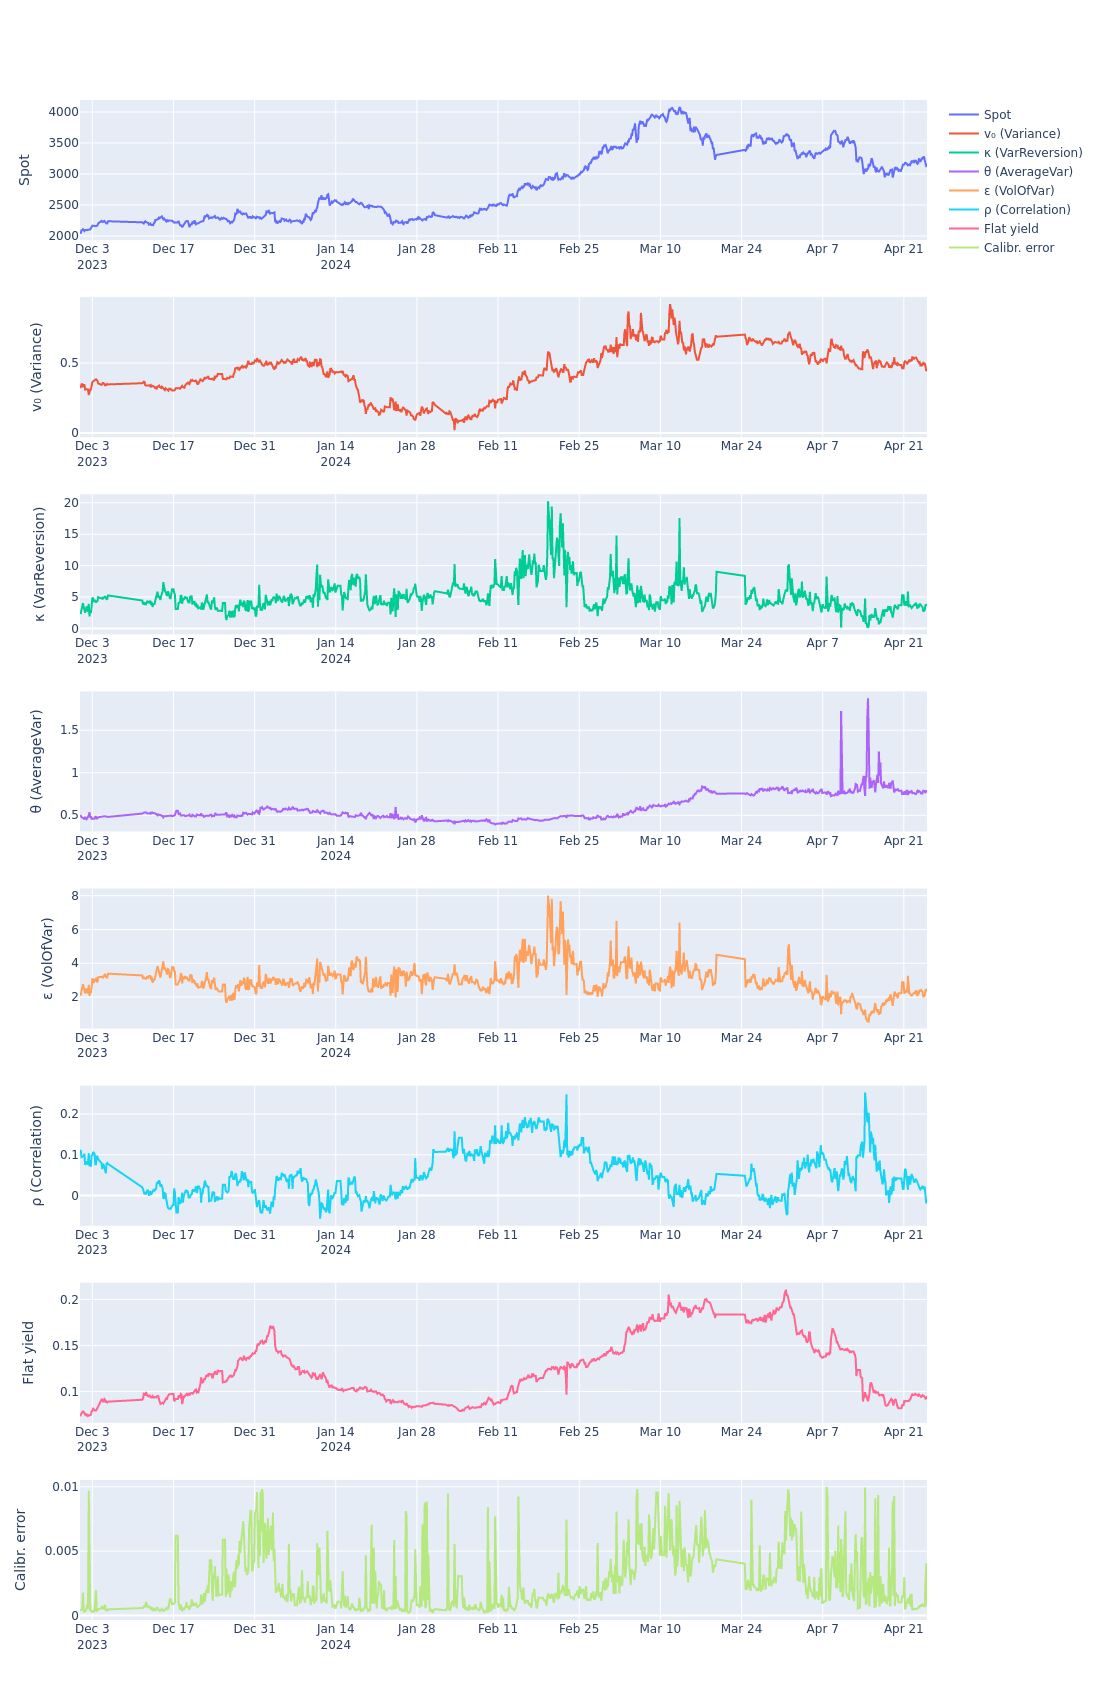

In [13]:
fig = plot_dynamics(market_data_resampled, calibr_data_resampled)
fig.update_layout(height=1700, width=1100)